In [1]:
import pandas as pd
import numpy as np
import requests
import json
import seaborn as sns
import urllib.request
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Fetching data from the API
url = 'https://data.gov.il/api/3/action/datastore_search?resource_id=57c5aef9-70f9-4b71-82fa-52304cfbd031&limit=1000'
with urllib.request.urlopen(url) as fileobj:
    data = fileobj.read().decode('utf-8')
    #print(data)

In [3]:
# Parsing the JSON response
import json
json_data = json.loads(data)
records = json_data['result']['records']
df = pd.DataFrame(records)
data = df.copy()

In [4]:
# Display the first few rows of the dataframe to understand its structure
data.head()

,_id,OID,SUMACCIDEN,ID,CITY,MainUse,POP_2018,TAZAREA,USETYPE,CITYCODE,...,TOTDRIVERS,MOTORCYCLE,TRUCK,BICYCLE,PRIVATE,VEHICLE,ACC_INDEX,YEARMONTH,Shape_Length,Shape_Area
0,1,-1,56,544,ראשון לציון,מגורים,9948,852978,מגורים,8300,...,89,22,1,4,40,75,65.652368,202308,3765.786446,8.529776e+05
1,2,-1,11,2172,טבריה,מגורים,6378,1475818,מגורים,6700,...,23,2,0,2,11,15,7.453496,202308,6981.506526,1.475818e+06
2,3,-1,20,1186,ירושלים,מגורים,12277,346241,מגורים,3000,...,32,2,0,1,17,27,57.763205,202308,3958.161078,3.462412e+05
3,4,-1,10,137,הרצלייה,מגורים,5341,499512,מגורים,6400,...,16,1,0,1,10,12,20.019541,202308,3065.801740,4.995120e+05
4,5,-1,44,1828,קריית אתא,שטח פתוח,0,508601,פנאי/טבע/ספורט,6800,...,97,2,3,0,68,79,86.511780,202308,3692.333819,5.086013e+05


In [5]:
data.columns

Index(['_id', 'OID', 'SUMACCIDEN', 'ID', 'CITY', 'MainUse', 'POP_2018',
       'TAZAREA', 'USETYPE', 'CITYCODE', 'USETYPECOD', 'DEAD', 'SEVER_INJ',
       'SLIGH_INJ', 'PEDESTRINJ', 'INJ0_19', 'INJ20_64', 'INJ65_', 'INJTOTAL',
       'TOTDRIVERS', 'MOTORCYCLE', 'TRUCK', 'BICYCLE', 'PRIVATE', 'VEHICLE',
       'ACC_INDEX', 'YEARMONTH', 'Shape_Length', 'Shape_Area'],
      dtype='object')

In [6]:
import re

# תבניות רגולריות להחלפה
patterns = [
    (r'\bתעשיה\+ מגורים\b', 'תעשיה+מגורים'),
    (r'\bמגורים\+ מכללה אקדמאית\b', 'מגורים+מכללה אקדמאית'),
    (r'\bתעשיה\+ מכללה\b', 'תעשיה+מכללה'),
    (r'\bמגורים\+ בית חולים\b', 'מגורים+בית חולים'),
    (r'\bמגורים\+ שטח פתוח\b', 'מגורים+שטח פתוח'),
    (r'\bמגורים\+ מסחר\b', 'מגורים+מסחר'),
    (r'\bמגורים \+ אצטדיון\b', 'מגורים+אצטדיון'),
    (r'\bמגורים\+ מוסד אקדמאי\b', 'מגורים+מוסד אקדמאי'),
    (r'\bאוניברסיטה\+ בית חולים\b', 'אוניברסיטה+בית חולים'),
    (r'\bפנאי וספורט\+ מגורים\b', 'פנאי וספורט+מגורים'),
    (r'\bמסחר\+ מתקן ספורט\+ מגורים\b', 'מסחר+מתקן ספורט+מגורים'),
    (r'\bמגורים\+ מוסדיי\b', 'מגורים+מוסדי'),
    (r'\bמגורים\+ מוסדי\b', 'מגורים+מוסדי'),
    (r'\bמתקן הנדסי\+ מגורים\b', 'מתקן הנדסי+מגורים'),
    (r'\bמגורים\+ פנאי ונופש\b', 'מגורים+פנאי ונופש'),
    (r'\bקריית חינוך\+ מכללה אקדמאית\b', 'קריית חינוך+מכללה אקדמאית'),
    (r'\bמתקן לתחבורה\+ מגורים\b', 'מתקן לתחבורה+מגורים'),
    (r'\bמתחם ציבורי\+ מכללה אקדמאית\b', 'מתחם ציבורי+מכללה אקדמאית'),
    (r'\bמוסדות ציבור\+ מכללה אקדמאית\b', 'מוסדות ציבור+מכללה אקדמאית'),
    (r'\bמגורים\+ מכללה אקדמאית\+ בית חולים\b', 'מגורים+מכללה אקדמאית+בית חולים'),
    (r'\bמתקן ספורט\+ מגורים\b', 'מתקן ספורט+מגורים')
]

# החלפת תבניות בדאטה
for pattern, replacement in patterns:
    data['MainUse'] = data['MainUse'].apply(lambda x: re.sub(pattern, replacement, x))



In [7]:
data['MainUse'].value_counts()


מגורים                             660
שטח פתוח                            95
לא ידוע                             65
תעשיה                               60
בסיס צבאי                            9
מיועד למגורים                        8
מגורים+מוסדי                         8
פנאי ונופש                           6
מתחם ציבורי                          5
בית עלמין                            5
בית חולים                            5
מגורים+מכללה אקדמאית                 5
תעשיה+מגורים                         4
אוניברסיטה                           4
תעשיה ומלאכה                         4
מוסדי                                4
תיירות ונופש                         4
תעשיה ומסחר                          4
מגורים+שטח פתוח                      3
מגורים+פנאי ונופש                    3
תשעיה                                2
מגורים+בית חולים                     2
שדה תעופה                            2
מתקן הנדסה                           2
שטח לדרכים                           2
נמל                      

In [8]:
print(data[data['POP_2018'] == 0]['MainUse'].value_counts())

שטח פתוח                      94
לא ידוע                       65
תעשיה                         51
בסיס צבאי                      9
מיועד למגורים                  8
פנאי ונופש                     5
בית עלמין                      5
בית חולים                      5
תעשיה ומלאכה                   4
תיירות ונופש                   4
אוניברסיטה                     4
מתחם ציבורי                    3
תעשיה ומסחר                    3
תשעיה                          2
נמל                            2
שטח לדרכים                     2
מגורים                         2
שדה תעופה                      2
מתקן הנדסה                     2
מחצבה                          1
קריית חינוך+מכללה אקדמאית      1
מוסדות ציבור                   1
ספורט                          1
מתקן מיחזור                    1
תשתיות                         1
שטח בבניה                      1
שמורת טבע                      1
מוסדות ציבור+מכללה אקדמאית     1
מוסדי                          1
תעשיה+מכללה                    1
קריית הממש

In [9]:
# מציאת הערך הממוצע של ה-POP_2018 רק עבור רשומות שערכם של 'POP_2018' לא שווה ל-0 ובעמודת 'MainUse' ערך המכיל 'מגורים'
median_population_nonzero_mainuse = data.loc[(data['POP_2018'] != 0) & (data['MainUse'] == 'מגורים'), 'POP_2018'].median()

# שינוי ערכי ה־0 בעמודת 'POP_2018' לערך הממוצע שקיבלנו
data.loc[(data['POP_2018'] == 0) & (data['MainUse'] == 'מגורים'), 'POP_2018'] = median_population_nonzero_mainuse

# בדיקה שלמעשה הערכים הוחלפו
print(data[data['POP_2018'] == 0]['MainUse'].value_counts())
# מצאנו שיש כמה ערכי 0 בעמודה של האוכלוסיה ומכיוון שזה לא הגיוני שיש 0 אוכלוסיה במגורים מילאנו בחציון

שטח פתוח                      94
לא ידוע                       65
תעשיה                         51
בסיס צבאי                      9
מיועד למגורים                  8
פנאי ונופש                     5
בית עלמין                      5
בית חולים                      5
תעשיה ומלאכה                   4
תיירות ונופש                   4
אוניברסיטה                     4
מתחם ציבורי                    3
תעשיה ומסחר                    3
תשעיה                          2
נמל                            2
שטח לדרכים                     2
שדה תעופה                      2
מתקן הנדסה                     2
מחצבה                          1
קריית חינוך+מכללה אקדמאית      1
מוסדות ציבור                   1
ספורט                          1
מתקן מיחזור                    1
תשתיות                         1
שטח בבניה                      1
שמורת טבע                      1
מוסדות ציבור+מכללה אקדמאית     1
מוסדי                          1
תעשיה+מכללה                    1
קריית הממשלה                   1
אתר מורשת 

In [10]:
data[data['CITYCODE'] == 0]['CITY'].value_counts()

בנימינה-גבעת עדה*            5
אריאל                        4
באקה אל-גרביה                4
דאלית אל-כרמל                4
מג'ד אל-כרום                 3
                            ..
כפר מסריק                    1
רגמ                          1
אלון מורה ברכה יצהר איתמר    1
אום בטין אל סייד             1
הר גילה                      1
Name: CITY, Length: 284, dtype: int64

In [11]:
columns_to_drop = ['_id', 'OID', 'ID', 'USETYPECOD','YEARMONTH']
data.drop(columns=columns_to_drop, inplace=True)


In [12]:
data

,SUMACCIDEN,CITY,MainUse,POP_2018,TAZAREA,USETYPE,CITYCODE,DEAD,SEVER_INJ,SLIGH_INJ,...,INJTOTAL,TOTDRIVERS,MOTORCYCLE,TRUCK,BICYCLE,PRIVATE,VEHICLE,ACC_INDEX,Shape_Length,Shape_Area
0,56,ראשון לציון,מגורים,9948,852978,מגורים,8300,0,14,51,...,65,89,22,1,4,40,75,65.652368,3765.786446,8.529776e+05
1,11,טבריה,מגורים,6378,1475818,מגורים,6700,0,1,19,...,20,23,2,0,2,11,15,7.453496,6981.506526,1.475818e+06
2,20,ירושלים,מגורים,12277,346241,מגורים,3000,0,4,25,...,29,32,2,0,1,17,27,57.763205,3958.161078,3.462412e+05
3,10,הרצלייה,מגורים,5341,499512,מגורים,6400,0,0,10,...,10,16,1,0,1,10,12,20.019541,3065.801740,4.995120e+05
4,44,קריית אתא,שטח פתוח,0,508601,פנאי/טבע/ספורט,6800,0,10,106,...,116,97,2,3,0,68,79,86.511780,3692.333819,5.086013e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,15,רמת השרון,מגורים,3906,293440,מגורים,2650,0,3,13,...,16,19,2,0,0,12,16,51.117745,2560.613740,2.934402e+05
996,3,יקנעם עילית,מגורים,2149,1189827,מגורים,240,0,1,2,...,3,4,0,0,0,4,4,2.521375,6699.620537,1.189827e+06
997,30,חופית נעורים כפר ויתקין בית ינאי מכמורת בית חי...,מגורים+מוסדי,6271,14391839,מגורים,0,1,13,72,...,86,69,5,5,1,38,56,2.084515,18694.291028,1.439184e+07
998,12,הזורעים אלומות פורייה - כפר עבודה פורייה - נוו...,מגורים,4138,29885695,מגורים,0,0,5,27,...,32,25,0,0,0,17,18,0.401530,53211.852368,2.988569e+07


In [13]:
# Check for missing values in each column
missing_values = data.isnull().sum()
missing_values

SUMACCIDEN        0
CITY              0
MainUse           0
POP_2018          0
TAZAREA           0
USETYPE           0
CITYCODE          0
DEAD            135
SEVER_INJ       135
SLIGH_INJ       135
PEDESTRINJ      135
INJ0_19         135
INJ20_64        135
INJ65_          135
INJTOTAL        135
TOTDRIVERS      135
MOTORCYCLE      135
TRUCK           135
BICYCLE         135
PRIVATE         135
VEHICLE         135
ACC_INDEX         0
Shape_Length      0
Shape_Area        0
dtype: int64

In [14]:
# Percentage of missing values
missing_percentage = (missing_values / len(data)) * 100

In [15]:
#תצוגה של הערכים החסרים והאחזוים שלהם
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_summary.sort_values(by='Percentage', ascending=False)

,Missing Values,Percentage
INJ20_64,135,13.5
MOTORCYCLE,135,13.5
VEHICLE,135,13.5
PRIVATE,135,13.5
BICYCLE,135,13.5
DEAD,135,13.5
SEVER_INJ,135,13.5
SLIGH_INJ,135,13.5
PEDESTRINJ,135,13.5
INJ0_19,135,13.5


In [16]:
# Fill missing values with 0
columns_with_missing_values = missing_summary[missing_summary['Missing Values'] > 0].index
data_filled = data.fillna(0)

In [17]:
# Verify if the missing values are filled
missing_values_after = data_filled.isnull().sum()
missing_values_after_summary = pd.DataFrame({'Missing Values After Filling': missing_values_after})
missing_values_after_summary[missing_values_after_summary['Missing Values After Filling'] > 0]
#חוזרת רשימה ריקה וזה אומר שאין ערכים חסרים


,Missing Values After Filling


In [18]:
data_filled[['DEAD', 'SEVER_INJ', 'SLIGH_INJ','PEDESTRINJ','INJ0_19','INJ20_64','INJ65_','INJTOTAL','TOTDRIVERS','MOTORCYCLE','TRUCK','BICYCLE','PRIVATE','VEHICLE']] = data_filled[['DEAD', 'SEVER_INJ', 'SLIGH_INJ','PEDESTRINJ','INJ0_19','INJ20_64','INJ65_','INJTOTAL','TOTDRIVERS','MOTORCYCLE','TRUCK','BICYCLE','PRIVATE','VEHICLE']].astype('int64')


In [19]:
# Summary statistics for numerical columns to assess the need for normalization
#numerical_columns = data_filled.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = data_filled.select_dtypes(include=[np.number]).columns
statistical_summary = data_filled[numerical_columns].describe()

statistical_summary.transpose()
#בדיקה של כל העמודות המספריות על מנת לבדוק את טווח הערכים שלהן

,count,mean,std,min,25%,50%,75%,max
SUMACCIDEN,1000.0,1.674000e+01,2.078943e+01,0.000000,2.750000,10.000000,2.300000e+01,2.010000e+02
POP_2018,1000.0,3.323257e+03,3.452677e+03,0.000000,0.000000,2875.500000,5.335750e+03,2.902200e+04
TAZAREA,1000.0,1.155787e+07,5.318930e+07,140532.000000,393122.500000,830103.000000,3.364000e+06,7.859678e+08
CITYCODE,1000.0,3.377874e+03,3.332946e+03,0.000000,0.000000,2715.000000,6.700000e+03,9.700000e+03
DEAD,1000.0,5.050000e-01,1.117687e+00,0.000000,0.000000,0.000000,1.000000e+00,1.100000e+01
SEVER_INJ,1000.0,3.307000e+00,4.525398e+00,0.000000,0.000000,2.000000,5.000000e+00,3.500000e+01
SLIGH_INJ,1000.0,2.696800e+01,3.827221e+01,0.000000,3.000000,14.000000,3.700000e+01,3.860000e+02
PEDESTRINJ,1000.0,3.893000e+00,6.667234e+00,0.000000,0.000000,1.000000,4.000000e+00,7.100000e+01
INJ0_19,1000.0,5.986000e+00,9.471616e+00,0.000000,0.000000,3.000000,8.000000e+00,1.100000e+02
INJ20_64,1000.0,2.121800e+01,3.013434e+01,0.000000,2.000000,11.000000,2.825000e+01,2.730000e+02


In [20]:
# Selecting numerical columns for normalization
#olumns_to_normalize = ['POP_2018', 'TAZAREA', 'TOTDRIVERS', 'MOTORCYCLE', 'TRUCK', 'BICYCLE', 'PRIVATE', 'VEHICLE', 'ACC_INDEX']

In [21]:
# Normalizing numerical columns
scaler = MinMaxScaler()
data_filled[numerical_columns] = scaler.fit_transform(data_filled[numerical_columns])

In [22]:
# Encoding categorical variables
onehot_encoder = OneHotEncoder(sparse_output=False)

categorical_columns = ['CITY', 'MainUse', 'USETYPE']
encoded_categorical = onehot_encoder.fit_transform(data_filled[categorical_columns])


In [23]:
# Creating a DataFrame from the encoded categorical variables
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=onehot_encoder.get_feature_names_out(categorical_columns))
encoded_categorical_df


,CITY_א ראם,CITY_א-טירה מזרח,CITY_א-שרפה מערב,CITY_אבו סנאן,CITY_אבו סנינא,CITY_אבו קורינאת (יישוב),CITY_אבו תלול,CITY_אביחיל,CITY_אבן ספיר,CITY_אום אל-פחם,...,MainUse_תעשיה ומסחר,MainUse_תעשיה+מגורים,MainUse_תעשיה+מכללה,MainUse_תשעיה,MainUse_תשתיות,USETYPE_מגורים,USETYPE_מוסדי/ציבורי,USETYPE_עתידי/לא ידוע,USETYPE_פנאי/טבע/ספורט,USETYPE_תעשיה/מסחר/מתקנים
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [24]:
# Dropping original categorical columns and concatenating the encoded ones
data_preprocessed = data_filled.drop(columns=categorical_columns)
data_preprocessed = pd.concat([data_preprocessed, encoded_categorical_df], axis=1)

In [25]:
# Displaying a summary of the transformed dataset
data_preprocessed.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SUMACCIDEN,1000.0,0.083284,0.103430,0.0,0.013682,0.049751,0.114428,1.0
POP_2018,1000.0,0.114508,0.118968,0.0,0.000000,0.099080,0.183852,1.0
TAZAREA,1000.0,0.014529,0.067686,0.0,0.000321,0.000878,0.004102,1.0
CITYCODE,1000.0,0.348234,0.343603,0.0,0.000000,0.279897,0.690722,1.0
DEAD,1000.0,0.045909,0.101608,0.0,0.000000,0.000000,0.090909,1.0
...,...,...,...,...,...,...,...,...
USETYPE_מגורים,1000.0,0.696000,0.460213,0.0,0.000000,1.000000,1.000000,1.0
USETYPE_מוסדי/ציבורי,1000.0,0.039000,0.193692,0.0,0.000000,0.000000,0.000000,1.0
USETYPE_עתידי/לא ידוע,1000.0,0.076000,0.265131,0.0,0.000000,0.000000,0.000000,1.0
USETYPE_פנאי/טבע/ספורט,1000.0,0.108000,0.310536,0.0,0.000000,0.000000,0.000000,1.0


מפה מתחילים ליצור עמודות חדשות באמצעות צירופים שונים

In [26]:
# Calculating new features: Accident density per population and per area
#This line calculates the accident density per population. It divides the number of accidents (`SUMACCIDEN`) by the product of the population in 2018 (`POP_2018`)
#and the maximum population squared plus 1. This calculation likely aims to normalize the accident count based on the population density, considering the maximum population value.
data_preprocessed['Accident_Density_Per_Population'] = data_preprocessed['SUMACCIDEN'] / (data_preprocessed['POP_2018'] * data_preprocessed['POP_2018'].max() + 1)

#This line calculates the accident density per area. It divides the number of accidents (`SUMACCIDEN`) by the product of the Total Analysis Zone area (`TAZAREA`)
#and the maximum area squared plus 1. This calculation likely aims to normalize the accident count based on the area size, considering the maximum area value.

data_preprocessed['Accident_Density_Per_Area'] = data_preprocessed['SUMACCIDEN'] / (data_preprocessed['TAZAREA'] * data_preprocessed['TAZAREA'].max() + 1)
#these calculations normalize the accident counts based on population and area sizes to provide insights into accident density per capita and per area, respectively.

In [27]:
# Displaying the first few rows to check the new features
data_preprocessed[['Accident_Density_Per_Population', 'Accident_Density_Per_Area']]

,Accident_Density_Per_Population,Accident_Density_Per_Area
0,0.207486,0.278355
1,0.044866,0.054634
2,0.069923,0.099476
3,0.042018,0.049729
4,0.218905,0.218803
...,...,...
995,0.065774,0.074612
996,0.013896,0.014905
997,0.122734,0.146595
998,0.052251,0.057524


In [28]:
#סכום שורות מכל עיר
city_counts = data['CITY'].value_counts()
print(city_counts)

ירושלים                  82
תל אביב -יפו             54
חיפה                     47
באר שבע                  28
פתח תקווה                27
                         ..
יסעור אחיהוד              1
עפרה                      1
כישור תובל לפידות פלך     1
שגב-שלום                  1
הר גילה                   1
Name: CITY, Length: 374, dtype: int64


In [29]:
# Simplifying the approach by selecting a subset of key features for clustering
#simplified_features = data_preprocessed[['Accident_Density_Per_Population', 'Accident_Density_Per_Area', 'ACC_INDEX', 'POP_2018']]

simplified_features = data_preprocessed[['VEHICLE','INJTOTAL', 'DEAD','CITYCODE' ,'Accident_Density_Per_Population','Accident_Density_Per_Area']]

In [30]:
# Performing K-Means clustering with a predetermined number of clusters (for demonstration, let's use 5 clusters)
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(simplified_features)

In [31]:
# Adding the cluster labels to the dataset
data_preprocessed['Cluster'] = cluster_labels

In [37]:
# Recalculate the cluster analysis with 5 clusters
cluster_analysis_summary= data_preprocessed.groupby('Cluster')[['VEHICLE','INJTOTAL', 'DEAD', 'Accident_Density_Per_Population', 'Accident_Density_Per_Area']].mean()

# Identify the city with the most accidents
# Assuming 'CITYCODE' represents the city, and 'SUMACCIDEN' is the total accidents which needs to be summed up
city_accidents_sum = data_preprocessed.groupby('CITYCODE')['SUMACCIDEN'].sum().idxmax()

# Evaluate the impact of population density on accidents
# Assuming 'POP_2018' is the population and dividing 'SUMACCIDEN' by 'POP_2018' to get accident rate per capita
data_preprocessed['Accidents_Per_Capita'] = data_preprocessed['SUMACCIDEN'] / data_preprocessed['POP_2018']
population_density_accident_correlation = data_preprocessed[['Accidents_Per_Capita', 'POP_2018']].corr().iloc[0,1]

# Identify where the death toll is higher
# Assuming 'DEAD' represents deaths, and analyzing by 'Cluster_5'
death_toll_by_cluster = data_preprocessed.groupby('Cluster')['DEAD'].mean().idxmax()

# Evaluate the impact of area on accidents
# Assuming 'TAZAREA' is the area and correlating it with 'SUMACCIDEN' to see the impact of area on accident numbers
area_accident_correlation = data_preprocessed[['SUMACCIDEN', 'TAZAREA']].corr().iloc[0,1]

(silhouette_avg, cluster_analysis_summary, city_accidents_sum, population_density_accident_correlation, death_toll_by_cluster, area_accident_correlation)


(0.511044433971492,
           VEHICLE  INJTOTAL      DEAD  Accident_Density_Per_Population  \
 Cluster                                                                  
 0        0.036846  0.038565  0.028071                         0.033547   
 1        0.054560  0.044982  0.021662                         0.051901   
 2        0.049381  0.040583  0.016162                         0.047149   
 3        0.271948  0.208688  0.075758                         0.258009   
 4        0.224319  0.264276  0.249446                         0.191269   
 
          Accident_Density_Per_Area  
 Cluster                             
 0                         0.036298  
 1                         0.059882  
 2                         0.052912  
 3                         0.299198  
 4                         0.206724  ,
 0.0,
 -0.09638730963850363,
 4,
 0.029212431464132615)

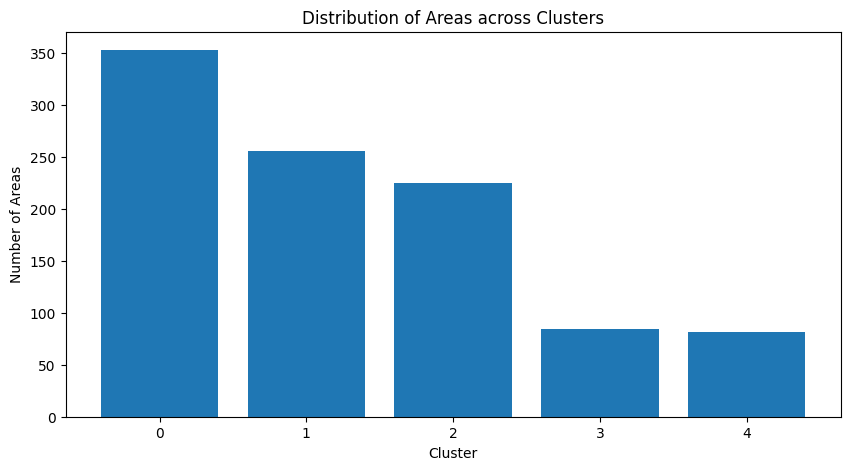

The silhouette score of the clustering:  0.511044433971492


In [45]:
# Visualizing the distribution of data points among the clusters
cluster_distribution = data_preprocessed['Cluster'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(cluster_distribution.index, cluster_distribution.values)
plt.title('Distribution of Areas across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Areas')
plt.xticks(range(5))
plt.show()

# Calculate the silhouette score for the clustering
silhouette_avg = silhouette_score(simplified_features, cluster_labels)
print("The silhouette score of the clustering: ", silhouette_avg)

In [38]:
# Displaying the centroids of each cluster
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=simplified_features.columns)
print("Cluster Centroids:")
print(cluster_centroids)


Cluster Centroids:
    VEHICLE  INJTOTAL      DEAD  CITYCODE  Accident_Density_Per_Population  \
0  0.036846  0.038565  0.028071  0.019671                         0.033547   
1  0.054560  0.044982  0.021662  0.819749                         0.051901   
2  0.049381  0.040583  0.016162  0.340504                         0.047149   
3  0.271948  0.208688  0.075758  0.637003                         0.258009   
4  0.224319  0.264276  0.249446  0.016015                         0.191269   

   Accident_Density_Per_Area  
0                   0.036298  
1                   0.059882  
2                   0.052912  
3                   0.299198  
4                   0.206724  


In [39]:
# Dataset mean values
dataset_mean = simplified_features.mean()

# Comparison with dataset mean
centroid_comparison = cluster_centroids - dataset_mean
print("Comparison with Dataset Mean:")
print(centroid_comparison)

Comparison with Dataset Mean:
    VEHICLE  INJTOTAL      DEAD  CITYCODE  Accident_Density_Per_Population  \
0 -0.042477 -0.034896 -0.017838 -0.328564                        -0.039547   
1 -0.024762 -0.028478 -0.024247  0.471514                        -0.021193   
2 -0.029941 -0.032877 -0.029747 -0.007730                        -0.025945   
3  0.192626  0.135228  0.029848  0.288769                         0.184915   
4  0.144996  0.190816  0.203537 -0.332220                         0.118175   

   Accident_Density_Per_Area  
0                  -0.045834  
1                  -0.022250  
2                  -0.029220  
3                   0.217066  
4                   0.124592  


In [40]:
# Extracting key features for analysis
key_features = ['INJTOTAL', 'DEAD', 'Accident_Density_Per_Population', 'Accident_Density_Per_Area']

# Descriptive statistics for key features by cluster
key_feature_stats = data_preprocessed.groupby('Cluster')[key_features].describe()
print("Key Feature Statistics by Cluster:")
print(key_feature_stats)

Key Feature Statistics by Cluster:
        INJTOTAL                                                              \
           count      mean       std       min       25%       50%       75%   
Cluster                                                                        
0          353.0  0.038565  0.042587  0.000000  0.002387  0.023866  0.062053   
1          256.0  0.044982  0.040849  0.000000  0.011933  0.033413  0.069212   
2          225.0  0.040583  0.044110  0.000000  0.007160  0.026253  0.059666   
3           84.0  0.208688  0.104035  0.097852  0.145585  0.176611  0.248210   
4           82.0  0.264276  0.170281  0.064439  0.160501  0.217184  0.292959   

                    DEAD            ... Accident_Density_Per_Population  \
              max  count      mean  ...                             75%   
Cluster                             ...                                   
0        0.195704  353.0  0.028071  ...                        0.054726   
1        0.193317  256.0

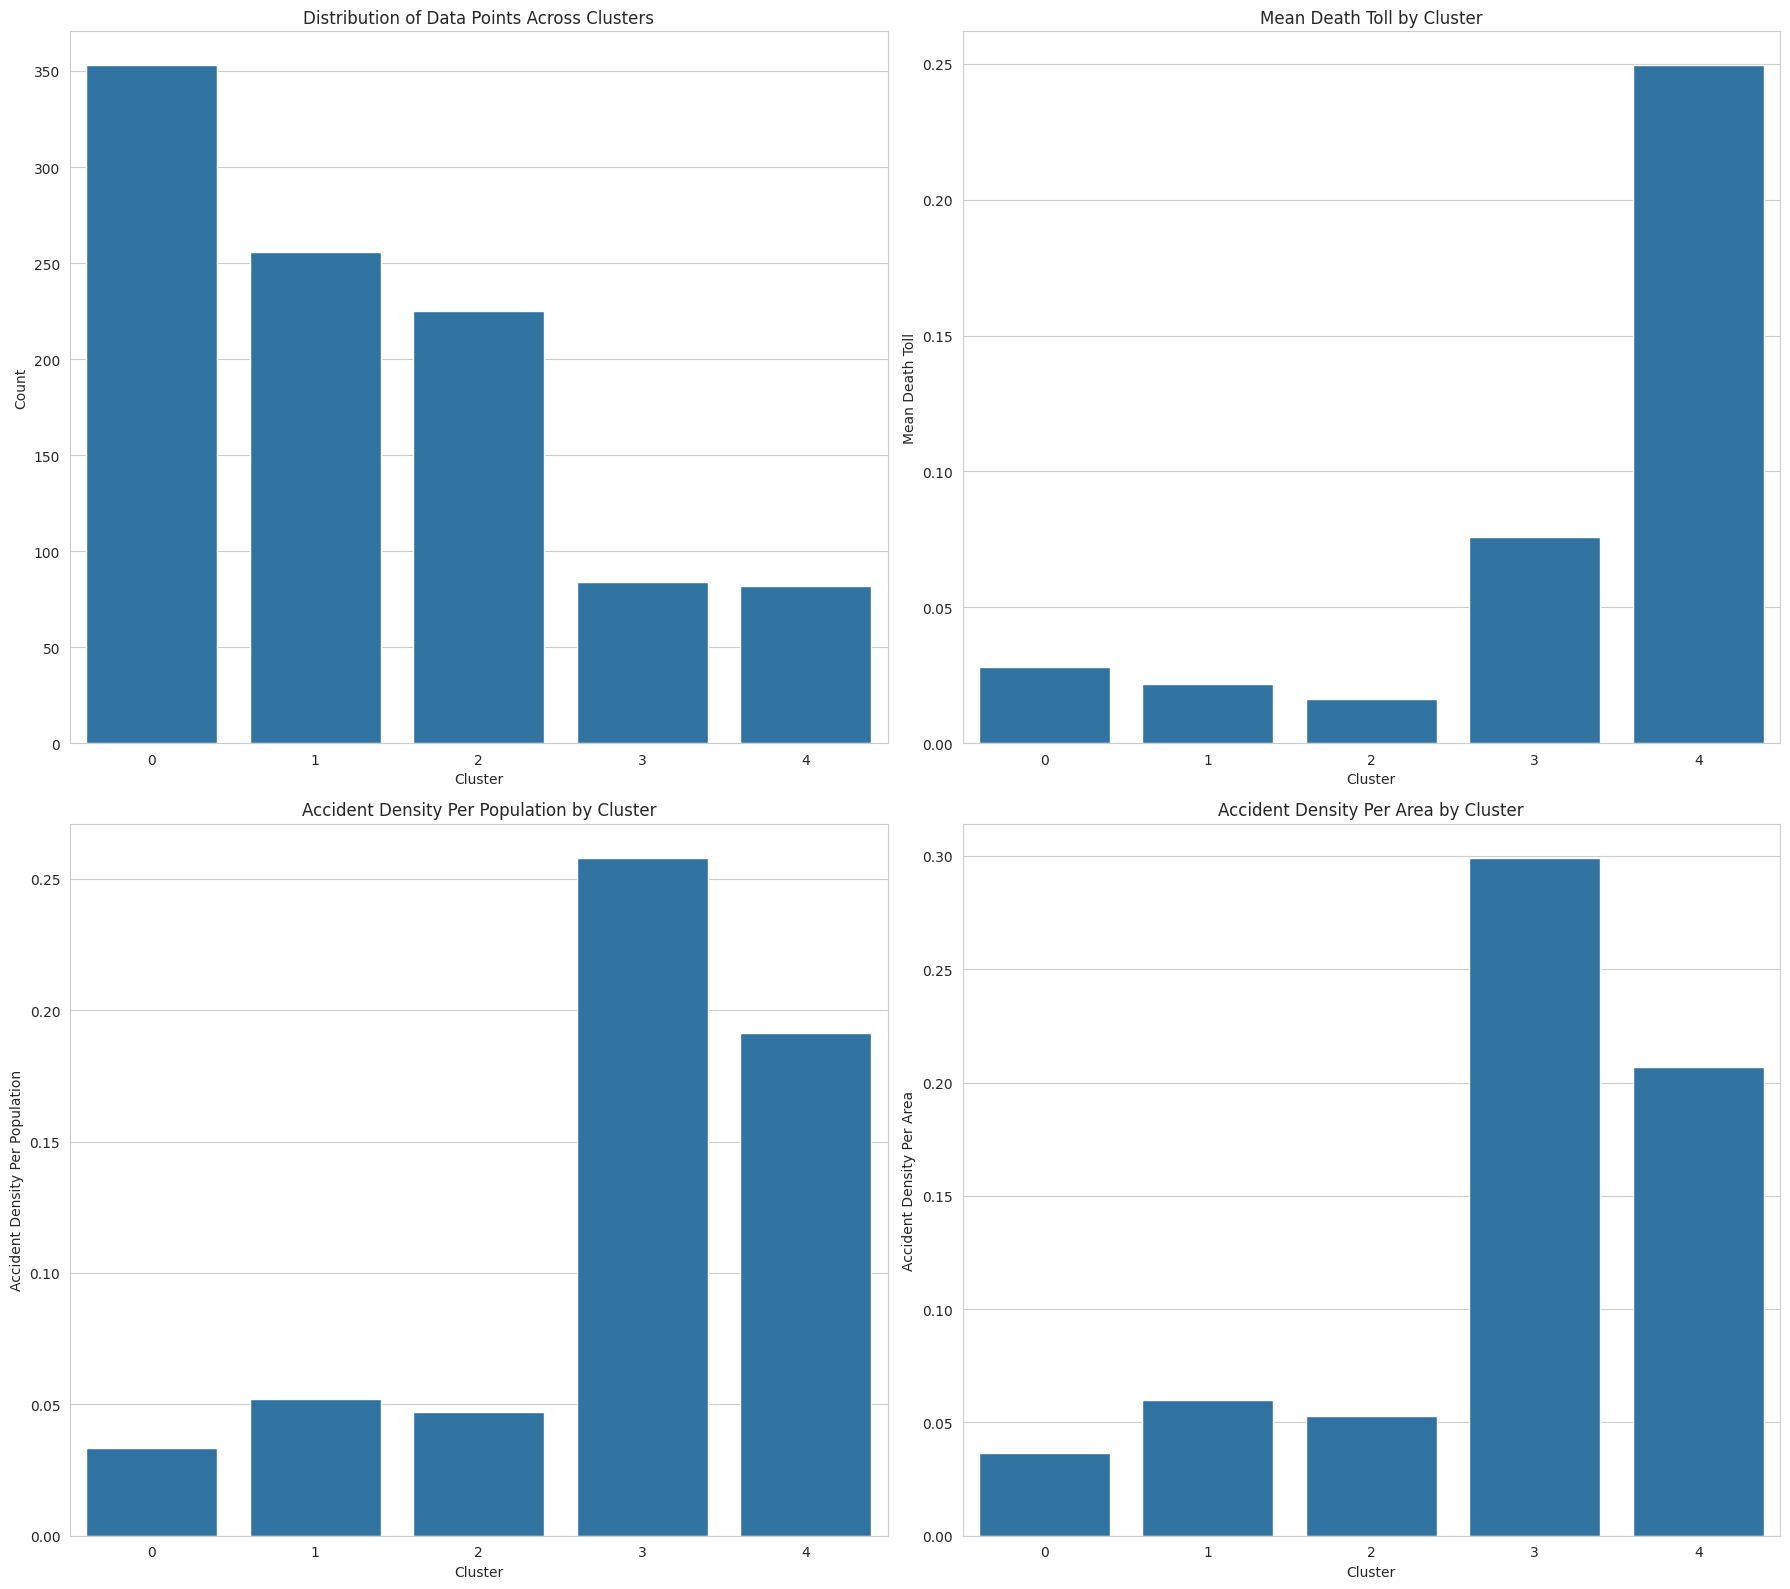

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a figure to hold the subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 16))

# Plot 1: Distribution of Clusters
sns.countplot(x='Cluster', data=data_preprocessed, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Data Points Across Clusters')
axs[0, 0].set_xlabel('Cluster')
axs[0, 0].set_ylabel('Count')

# Plot 2: Mean Death Toll by Cluster
cluster_means_death = data_preprocessed.groupby('Cluster')['DEAD'].mean().reset_index()
sns.barplot(x='Cluster', y='DEAD', data=cluster_means_death, ax=axs[0, 1])
axs[0, 1].set_title('Mean Death Toll by Cluster')
axs[0, 1].set_xlabel('Cluster')
axs[0, 1].set_ylabel('Mean Death Toll')

# Plot 3: Accident Density Per Population by Cluster
cluster_means_density_pop = data_preprocessed.groupby('Cluster')['Accident_Density_Per_Population'].mean().reset_index()
sns.barplot(x='Cluster', y='Accident_Density_Per_Population', data=cluster_means_density_pop, ax=axs[1, 0])
axs[1, 0].set_title('Accident Density Per Population by Cluster')
axs[1, 0].set_xlabel('Cluster')
axs[1, 0].set_ylabel('Accident Density Per Population')

# Plot 4: Accident Density Per Area by Cluster
cluster_means_density_area = data_preprocessed.groupby('Cluster')['Accident_Density_Per_Area'].mean().reset_index()
sns.barplot(x='Cluster', y='Accident_Density_Per_Area', data=cluster_means_density_area, ax=axs[1, 1])
axs[1, 1].set_title('Accident Density Per Area by Cluster')
axs[1, 1].set_xlabel('Cluster')
axs[1, 1].set_ylabel('Accident Density Per Area')

plt.tight_layout()
plt.show()


In [41]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score for the clustering
silhouette_avg = silhouette_score(simplified_features, cluster_labels)
print("The silhouette score of the clustering: ", silhouette_avg)


The silhouette score of the clustering:  0.511044433971492


In [42]:
# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(simplified_features)
    score = silhouette_score(simplified_features, kmeans.labels_)
    silhouette_scores.append(score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

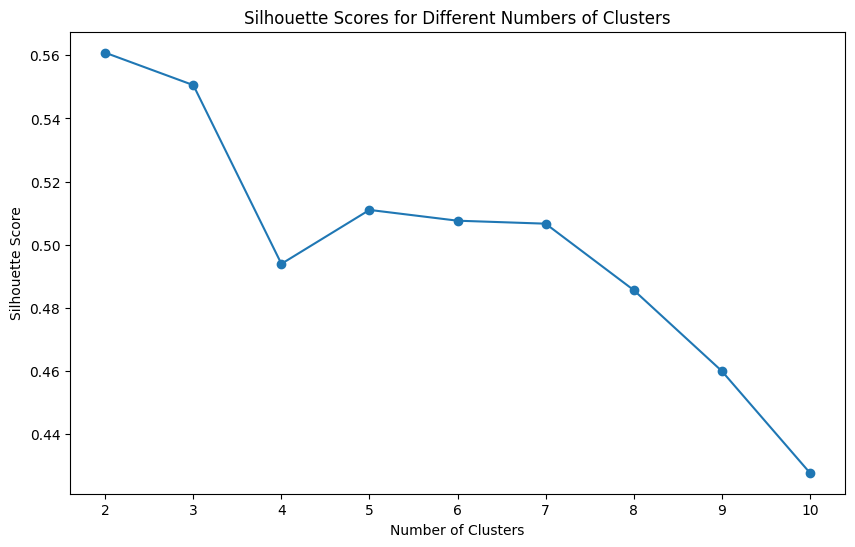

In [43]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.show()